In [1]:
%gui wx
import sys
import os

notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist

Gtk-Message: 14:06:41.336: Failed to load module "canberra-gtk-module"


In [2]:

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/Data"

import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess

In [3]:
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

14:07:07: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:07:07: Debug: Adding duplicate animation handler for '1' type
14:07:07: Debug: Adding duplicate animation handler for '2' type
14:07:07: Debug: Adding duplicate image handler for 'Windows bitmap file'
14:07:07: Debug: Adding duplicate animation handler for '1' type
14:07:07: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:1059): Gtk-CRITICAL **: 14:07:08.417: gtk_window_resize: assertion 'height > 0' failed


## 1.0 Downloading Data

In [4]:
dataset_id = 'ds000171'
subject = 'control01' 

sample_path = "/home/jovyan/Data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

mkdir_no_exist(bids_root)

subject_dir = 'sub-{}'.format(subject)

#download dataset

#subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
#                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
#                "--include", subject_dir # Effectively get all data
#               ], check=True)
###################
# Create folders relevant for preprocessing.
###################
mkdir_no_exist(op.join(bids_root, 'derivatives'))
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')
mkdir_no_exist(preproc_root)
mkdir_no_exist(op.join(preproc_root, 'sub-control01'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'anat'))
mkdir_no_exist(op.join(preproc_root, 'sub-control01', 'func'))

In [5]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))


(ipykernel_launcher.py:1059): Gdk-WARNING **: 14:07:19.680: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [9]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv


## 1.1 Brain Extraction and Coregistration fMRI to Anatomical

### 1.1.a Brain Extraction

In [7]:
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """

    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')
get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)

Done with BET.


#### Observing the resulting mask

In [10]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz'))
fsleyesDisplay.load(resulting_mask_path)

#### Manually Improving the Fit before applying the mask
Manually done on FSL 

In [11]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):

    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The original brain
betted_brain_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz') # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask.nii.gz') # The mask to use

# Applying the mask
apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)


#### Quality Check

In [12]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

In [ ]:
print_dir_tree(bids_root, max_depth=5)

### 1.1.b Coregistration fMRI to Anatomical

#### Step 1: Align Anatomical Mask to One Volume of the fMRI Runs
Selecting an "Anchor" reference fMRI volume for aligning the anatomical brain mask to the fMRI space

In [14]:
# Step 1: Align Anatomical Mask to One Volume of the fMRI Runs
fmri_run_path = op.join(bids_root,'sub-control01', 'func', 'sub-control01_task-music_run-1_bold.nii.gz')
processing_path = op.join(preproc_root, 'sub-control01', 'func', 'reference_volume.nii.gz')

# Use the middle frame index as the reference volume
img = nib.load(fmri_run_path)
fmri_data_1 = img.get_fdata()
reference_frame = int(fmri_data_1.shape[3]/2)
subprocess.run(["fslroi", fmri_run_path, processing_path, str(reference_frame), "1"], check=True)

CompletedProcess(args=['fslroi', '/home/jovyan/Data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '52', '1'], returncode=0)

#### Step 2: Coregister the Anatomical Image to the Reference fMRI Volume
Aligning the anatomical image to the reference volume

In [15]:
# Step 2: Coregister the Anatomical Image to the Reference fMRI Volume
anatomical_path = op.join(bids_root,'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')
coregistered_path = op.join(preproc_root, 'sub-control01', 'anat')
# Running flirt with mutual info cost function
subprocess.run([
    "flirt", "-in", anatomical_path, "-ref", processing_path,
    "-out", op.join(coregistered_path,"coregistered_anatomical.nii.gz"), "-omat", op.join(coregistered_path,"anat2fmri.mat"),
    "-dof", "6", "-cost", "mutualinfo"
], check=True)

CompletedProcess(args=['flirt', '-in', '/home/jovyan/Data/dataset/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz', '-ref', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '-out', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/coregistered_anatomical.nii.gz', '-omat', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/anat2fmri.mat', '-dof', '6', '-cost', 'mutualinfo'], returncode=0)

#### Step 3: Apply the transformation to the Brain Mask

In [16]:
# Step 3: Apply Transformation to the Brain Mask
subprocess.run([
    "flirt", "-in", op.join(coregistered_path,"sub-control01_T1w_mask.nii.gz"), "-ref", processing_path,
    "-applyxfm", "-init", op.join(coregistered_path, "anat2fmri.mat"), "-out", op.join(coregistered_path,"aligned_brain_mask.nii.gz"),
    "-interp", "nearestneighbour"
], check=True)

CompletedProcess(args=['flirt', '-in', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/sub-control01_T1w_mask.nii.gz', '-ref', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/reference_volume.nii.gz', '-applyxfm', '-init', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/anat2fmri.mat', '-out', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '-interp', 'nearestneighbour'], returncode=0)

#### Step 4: Applying the mask to every fMRI runs

In [17]:
# Step 4: Applying the mask to every fMRI runs
fmri_runs_path = op.join(bids_root,'sub-control01', 'func')
output_fmri_path = op.join(preproc_root, 'sub-control01', 'func')
# Apply mask to fMRI_run1
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-1_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run1.nii.gz")], check=True)

# Apply mask to fMRI_run2
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-2_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run2.nii.gz")], check=True)

# Apply mask to fMRI_run3
subprocess.run(["fslmaths", op.join(fmri_runs_path, 'sub-control01_task-music_run-3_bold.nii.gz'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(output_fmri_path,"masked_fMRI_run3.nii.gz")], check=True)

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz', '-mas', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/masked_fMRI_run3.nii.gz'], returncode=0)

#### Quality Check of the Masked fMRI runs

In [91]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(output_fmri_path,"masked_fMRI_run3.nii.gz"))

## 1.2 Standardizing & Concatenating Data
The standardization considers only non-zero values (brain region) to avoid considering background voxels

In [ ]:
"""
# Finding the runs matching the structure run-*
fmri_paths = glob.glob(op.join(output_fmri_path, 'masked_fMRI_run*.nii.gz'))

# List to hold the standardized data arrays from each run
standardized_fmri_data = []

# Loop through each run file and load it
for i, run_path in enumerate(fmri_paths):
    img = nib.load(run_path)
    data = img.get_fdata()  # Extract the data as a numpy array
    
    # Standardize data (z-scoring)
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    print("Standardizing run {} with mean: {} and std: {}".format(i+1, round(mean,3), round(std,3)))
    
    # Append standardized data for concatenation
    standardized_fmri_data.append(standardized_data)

# Concatenate the standardized runs along the time dimension (4th dimension)
concatenated_data = np.concatenate(standardized_fmri_data, axis=3)

# Create a new NIfTI image for the concatenated data
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))
print("Concatenation complete and saved as concatenated_bold.nii.gz")
"""

In [20]:
# Finding the runs matching the structure run-*
fmri_paths = glob.glob(op.join(output_fmri_path, 'masked_fMRI_run*.nii.gz'))
mask_path = op.join(coregistered_path,"aligned_brain_mask.nii.gz")  # Each run uses the same mask

# Load the brain mask and converting to boolean for masking
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata().astype(bool)

# List to hold the standardized data arrays from each run
standardized_fmri_data = []

# Loop through each run file and load it
for i, run_path in enumerate(fmri_paths):
    
    # Extracting the data as a numpy array
    img = nib.load(run_path)
    data = img.get_fdata()  

    # Masking the data to include only the brain region
    brain_data = data[mask_data]

    # Computing the mean and std only within the brain region
    mean = np.mean(brain_data)
    std = np.std(brain_data)
    print("Standardizing run {} with mean: {} and std: {}".format(i+1, round(mean, 3), round(std, 3)))

    # Standardize within the brain region and set background to 0
    standardized_data = np.zeros_like(data)
    standardized_data[mask_data] = (brain_data - mean) / std

    # Append standardized data for concatenation
    standardized_fmri_data.append(standardized_data)

# Concatenate the standardized runs along the time dimension (4th dimension)
concatenated_data = np.concatenate(standardized_fmri_data, axis=3)

# Create a new NIfTI image for the concatenated data
concatenated_img = nib.Nifti1Image(concatenated_data, img.affine, img.header)

# Save the concatenated image
nib.save(concatenated_img, op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))
print("Concatenation complete and saved as concatenated_bold.nii.gz")

Standardizing run 1 with mean: 900.528 and std: 265.361
Standardizing run 2 with mean: 904.879 and std: 264.984
Standardizing run 3 with mean: 898.554 and std: 264.355
Concatenation complete and saved as concatenated_bold.nii.gz


#### Verification: the concatenated data should have mean = 0.0, std = 1.0

In [21]:
print("Resulting concatenated data has mean: {} and std: {}".format(round(np.mean(concatenated_data[mask_data]),3), round(np.std(concatenated_data[mask_data]),3)))

Resulting concatenated data has mean: 0.0 and std: 1.0


In [ ]:
print_dir_tree(bids_root, max_depth=5)

#### Quality Check

In [92]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func', 'concatenated_bold.nii.gz'))

## 1.3 Pre-processing Data

### 1.3.PP1 - Motion Correction

In [24]:
from fsl.wrappers import mcflirt

path_original_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [ ]:
print_dir_tree(bids_root, max_depth=5)

In [25]:
# Looking at the time series
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_moco_data)

### Observing the motion correction parameters

In [26]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.001611,-0.000745,-0.000254,-0.023863,0.044494,-0.019012
1,0.001462,-0.000622,-0.000295,-0.026743,0.060250,-0.006063
2,0.001486,-0.000858,-0.000218,-0.020690,0.052384,-0.006059
3,0.001344,-0.000857,-0.000213,-0.014722,0.069229,0.023413
4,0.001119,-0.000934,-0.000126,-0.014922,0.073530,0.044940
...,...,...,...,...,...,...
310,0.007037,-0.001502,-0.000785,-0.015571,0.438815,0.404385
311,0.007122,-0.001624,-0.000813,-0.016385,0.424060,0.399801
312,0.006959,-0.001619,-0.000831,-0.016423,0.436654,0.400272
313,0.007019,-0.001637,-0.000835,-0.025250,0.422393,0.385438


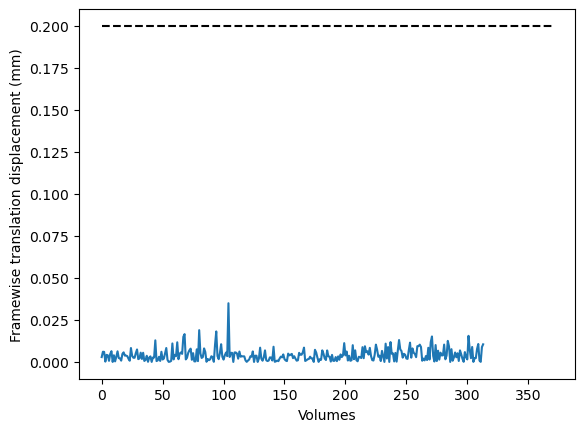

In [27]:
import matplotlib.pyplot as plt
#%matplotlib inline

# Getting the translation and computing the interframe difference  
trans_x = mot_params["Translation x"]
disp_x = np.diff(trans_x)

# Thresholding in absolute value above 0.2mm 
threshold=0.2

#Plotting
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

In [28]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere

    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [46]:
#threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))
threshold = 0.2

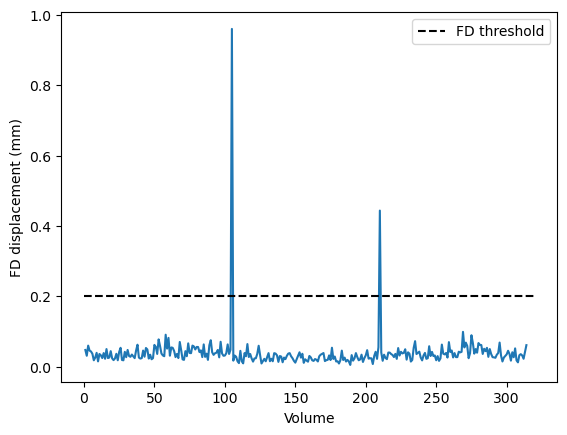

In [47]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 320,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [48]:
motion_artifacts = np.where(fd > threshold)[0] + 1
print(motion_artifacts)

[105 210]


### 1.3.PP2 - Smoothing

#### Step 1: Smoothing to 6 mm

In [32]:
output_path = op.join(preproc_root, 'sub-control01', 'func','concatenated_bold_moco')
cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco', '-s', '2.547987090198743', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm'], returncode=0)

In [34]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path + '_smoothed-6mm')

#### Step 2: Applying the mask to set background voxels to 0

In [35]:
# Applying again a mask to remove the background post-smoothing
subprocess.run(["fslmaths", op.join(output_path + '_smoothed-6mm'), "-mas", op.join(coregistered_path,"aligned_brain_mask.nii.gz"), op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz")], check=True)

CompletedProcess(args=['fslmaths', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/concatenated_bold_moco_smoothed-6mm', '-mas', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/anat/aligned_brain_mask.nii.gz', '/home/jovyan/Data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/pre-processed_fmri.nii.gz'], returncode=0)

#### Quality Check

In [93]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz"))

## ---- End of pre-processing ------

Test: offsetting background to -5

In [38]:
# fMRI data
fmri_path = op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz")
fmri_img = nib.load(fmri_path)
fmri_data = fmri_img.get_fdata()

# mask data
mask_path = op.join(coregistered_path,"aligned_brain_mask.nii.gz")
mask_img = nib.load(mask_path)
mask_data = mask_img.get_fdata()

# Setting background to -5 using the mask
fmri_data[mask_data==0] = -5

# Saving the data
output_path = op.join(preproc_root, 'sub-control01', 'func',"test_offset_fmri.nii.gz")
offset_fmri_img = nib.Nifti1Image(fmri_data, fmri_img.affine, fmri_img.header)
nib.save(offset_fmri_img, output_path)

In [94]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(output_path)
fsleyesDisplay.load(op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz"))

# Applying the GLM at single-subject level

<p style="font-size:25px;">$$Y = X\beta + \epsilon$$</p>


In [ ]:
# Importing relevant libraries
#TODO: clean the cells below by gathering the imports here

## Design Matrix

In [50]:
# Example data for each run (replace with actual file paths)
#run_paths = ["run1.tsv", "run2.tsv", "run3.tsv"]
df_run_1 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
df_run_2 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
df_run_3 = pd.read_csv(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

dfs = [df_run_1, df_run_2, df_run_3]
dataframes = []
offset = 0

for df in dfs:
    # Adjust onset times
    df['onset'] += offset
    
    # Append the adjusted dataframe
    dataframes.append(df)
    
    # Update offset for next run
    offset = df['onset'].iloc[-1] + df['duration'].iloc[-1]  # End of last event

# Concatenate all runs into one design matrix
df_concatenated = pd.concat(dataframes, ignore_index=True)
df_concatenated.head(56)

,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


## Basic Design Matrix (Without drifts and outliers) 

#### Step 1: Fit the GLM

In [51]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

fmri_img = op.join(preproc_root, 'sub-control01', 'func',"pre-processed_fmri.nii.gz")
fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, df_concatenated)

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


#### Step 2: Plot the design matrix

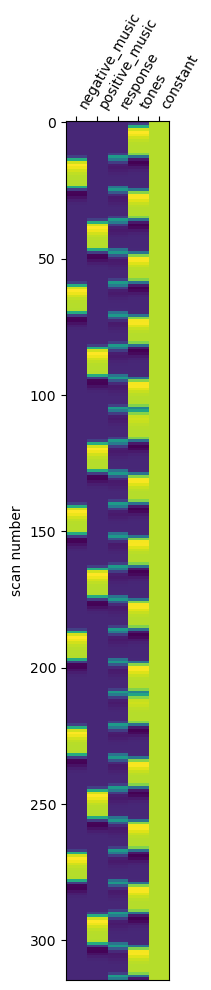

In [53]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0], rescale=False)
plt.show()

## Including Regressors in the Model

### Including drift

In [54]:
# Creation of the drift model: Order 1-2-3
from nilearn.glm.first_level.design_matrix import _make_drift

# Timing: from t_0 = 0 to t_end = 936 - TR - 1 = 932=> -1 because we start at 0
column_values, column_names = _make_drift(drift_model='polynomial', frame_times=np.asarray(list(range(0, 943, 3))), order=3, high_pass=None)

In [55]:
design_mat = fmri_glm.design_matrices_[0]
for (col, name) in zip(column_values.T, column_names):
    design_mat[name] = col

### Including motion artifacts

In [56]:
print(fd.size)

314


In [57]:
design_mat_regged = design_mat.copy()
volumes_number = fd.size + 1 # Number of volume = timeseries
for i, volume in enumerate(motion_artifacts):
    reg = np.zeros((volumes_number,))*0.0
    reg[volume-1] = 1.0 # adding a regressor at the specific location of the artifact (-1 because we added +1 before)
    design_mat_regged['motion outlier#' + str(i+1)] = reg

#### Step 1: Fit the GLM

In [62]:
fit_glm = FirstLevelModel(t_r=3,
                           drift_model='None',
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           high_pass=.01)

# Fit the model to our design and data
fit_glm = fit_glm.fit(fmri_img, design_matrices=[design_mat_regged] )

/opt/conda/lib/python3.11/site-packages/nilearn/glm/first_level/first_level.py:707: UserWarning: Mean values of 0 observed. The data have probably been centered.Scaling might not work as expected
  Y, _ = mean_scaling(Y, self.signal_scaling)


#### Step 2: Plot the design matrix

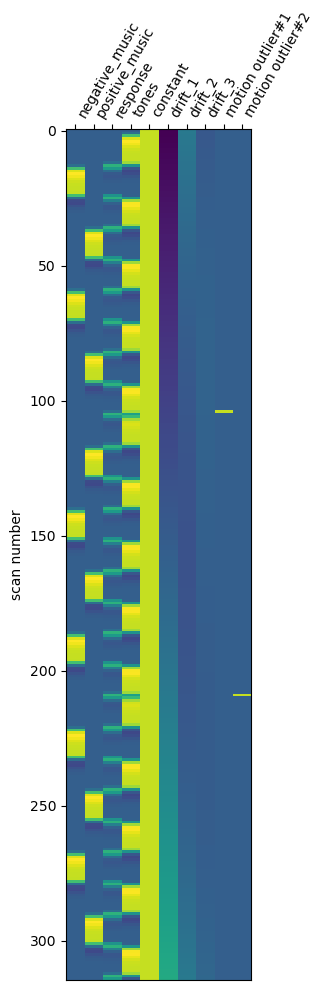

In [66]:
plot_design_matrix(design_mat_regged, rescale=False)#, output_file = op.join(bids_root, "design_matrix.png"))
plt.show()

## 3. Beta/Statistical Maps

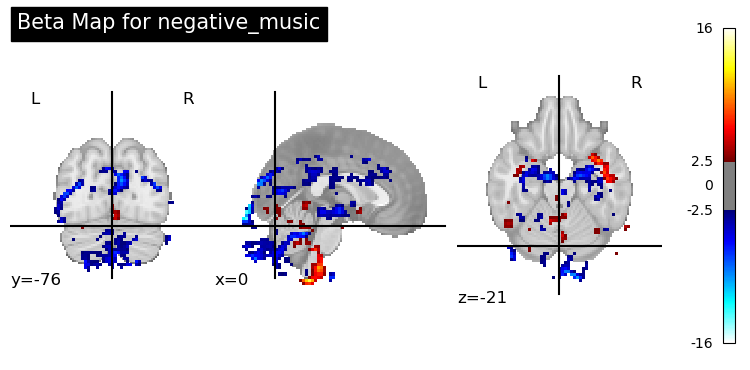

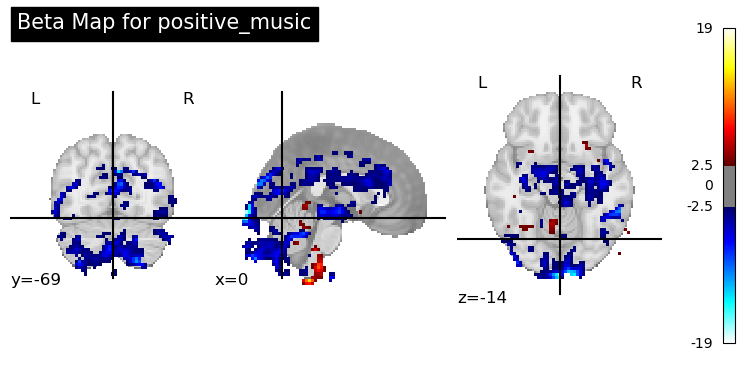

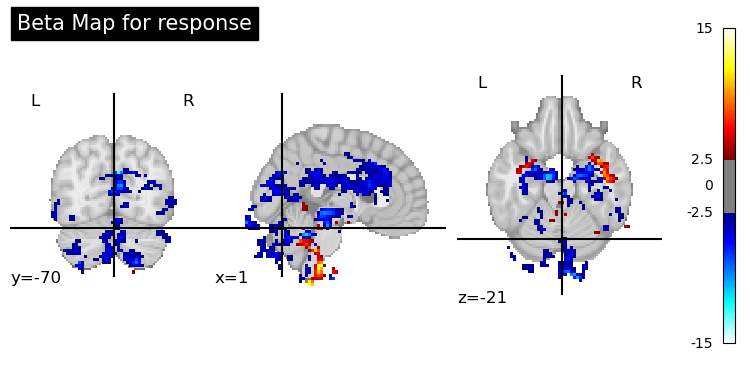

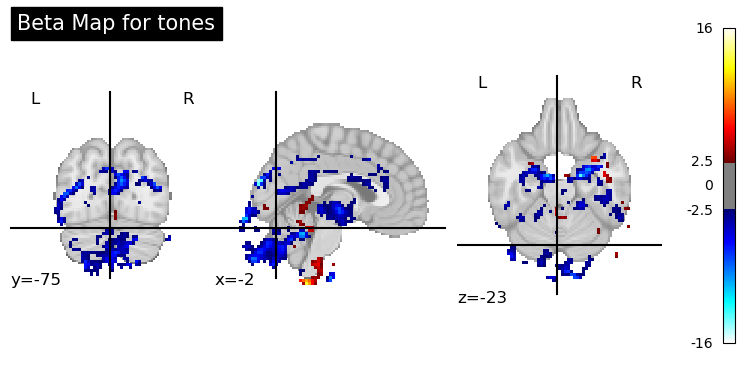

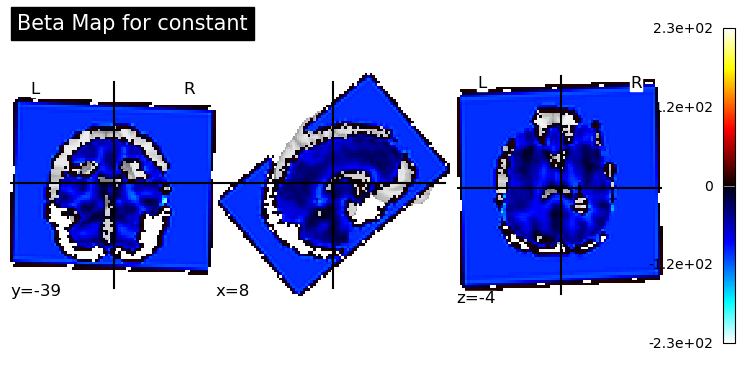

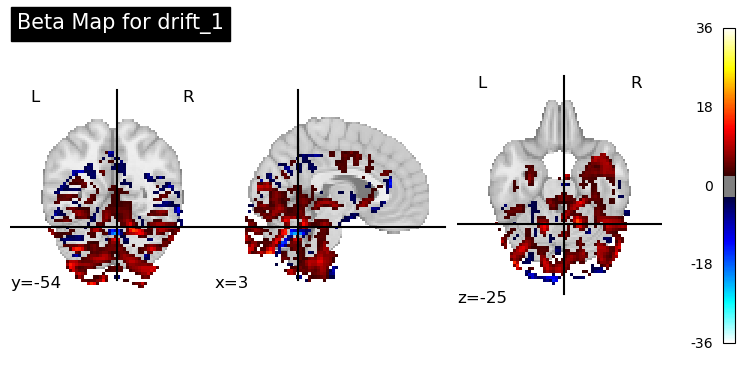

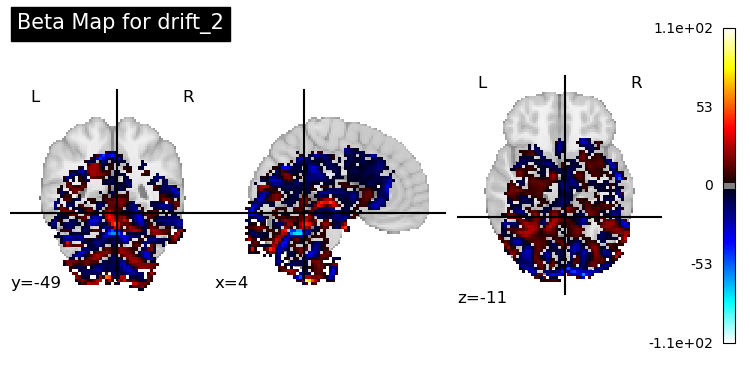

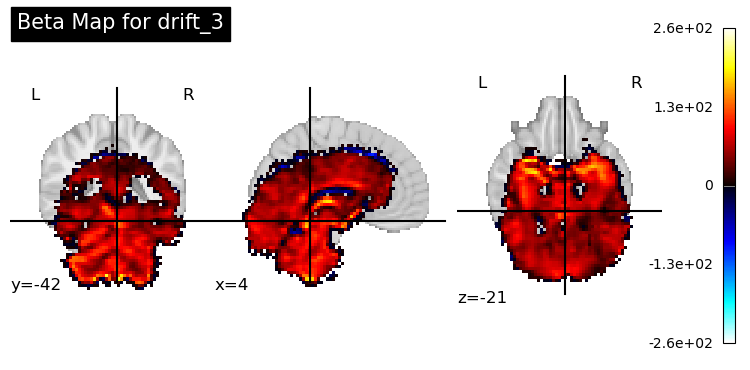

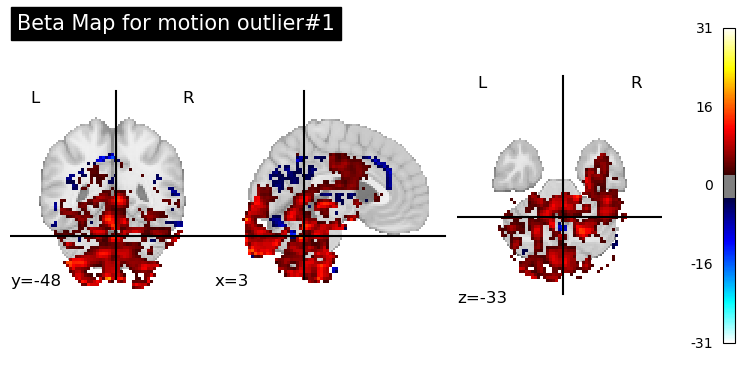

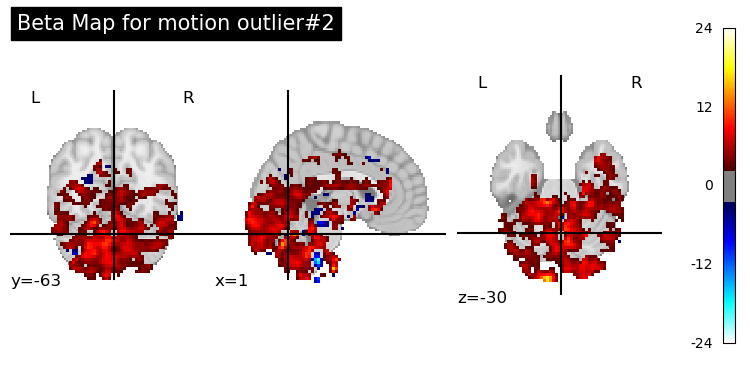

In [95]:
from nilearn.plotting import plot_stat_map
# Get regressor names from the design matrix
regressor_names = design_mat_regged.columns.tolist()  

# Loop over each regressor and plot its beta map
for regressor in regressor_names:
    # Compute contrast for the specific regressor (=>beta map for that regressor)
    beta_map = fit_glm.compute_contrast(regressor, output_type='effect_size')
    
    # Plot the beta map
    display = plot_stat_map(beta_map, title=f'Beta Map for {regressor}', threshold=2.5)
    plt.show()

## Building the contrast

[0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
(315, 10)


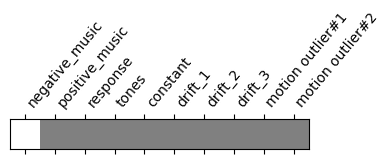

In [126]:
# Initialize contrast with values for "positive_music" and "negative_music" and pad with zeros for other columns
positive_minus_negative = np.array([0.01, 0] + [0] * (design_mat_regged.shape[1] - 2))
#positive_minus_negative[4] = 1
# Plot the contrast matrix
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(positive_minus_negative, design_matrix=design_mat_regged)


#REMOVE PRINTS
print(positive_minus_negative)
print(design_mat_regged.shape)

In [127]:
#z-score map of the beta coefficients of active minus rest
import nibabel as nib
z_map = fit_glm.compute_contrast(positive_minus_negative,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

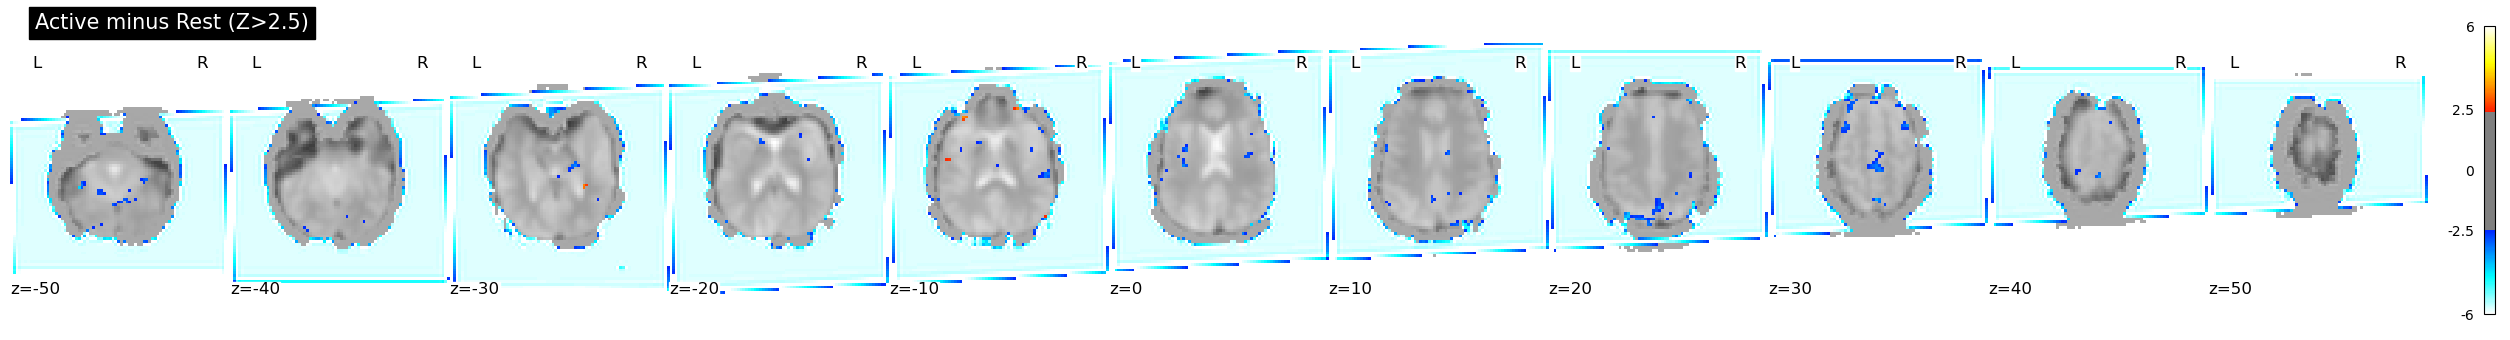

In [130]:
from nilearn.image import mean_img
threshold=2.5
mean_img_ = mean_img(fmri_img),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

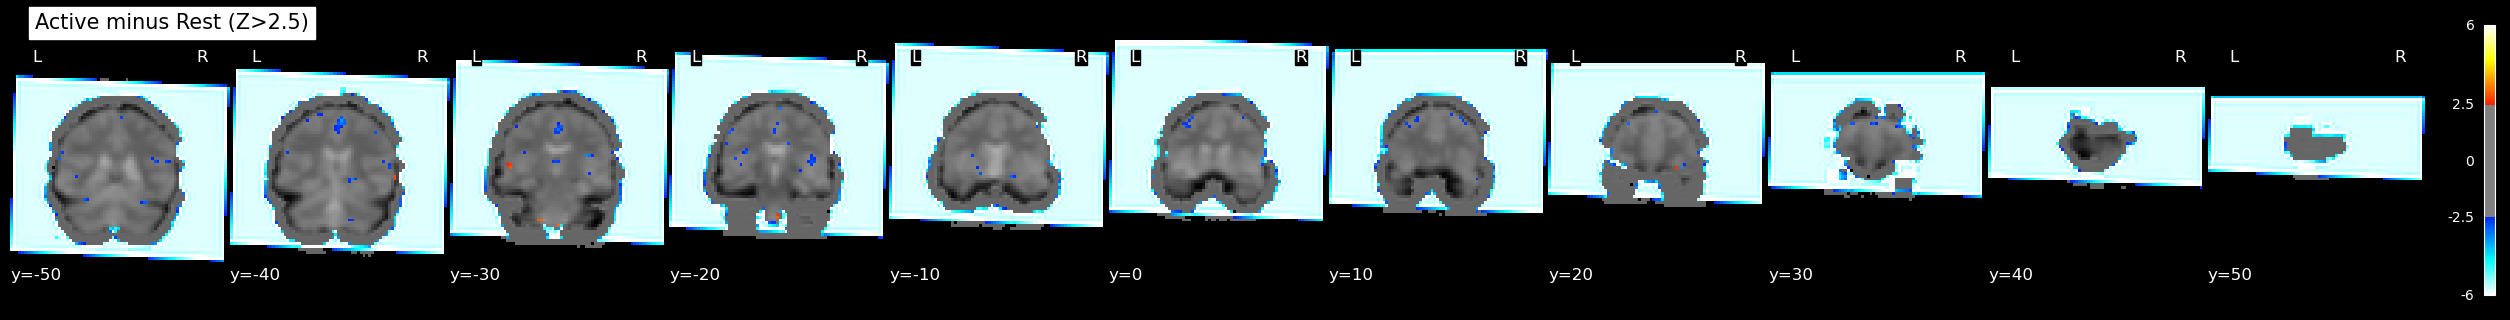

In [129]:
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='y', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

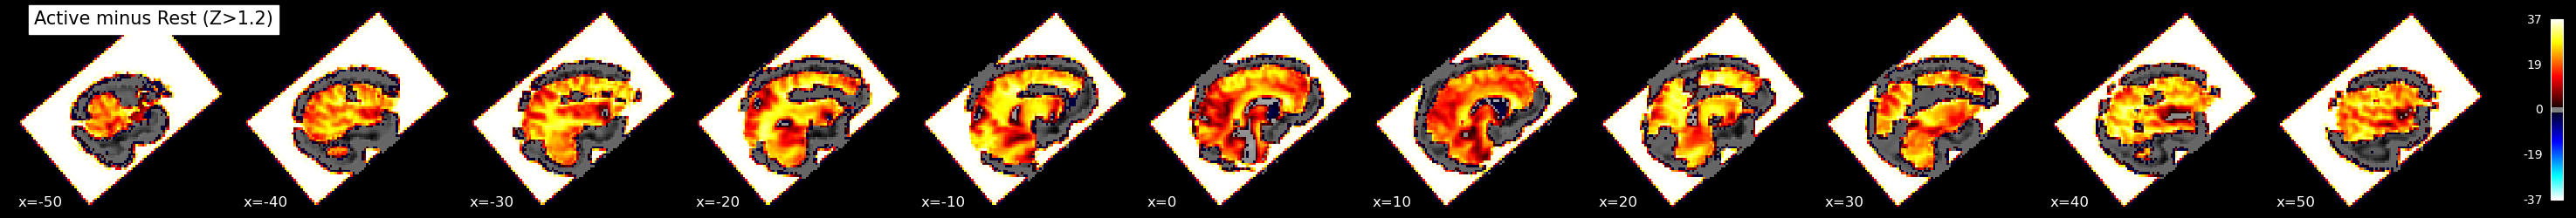

In [88]:
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='x', cut_coords=[-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50], black_bg=True,
              title=f'Active minus Rest (Z>{threshold})')
plt.show()

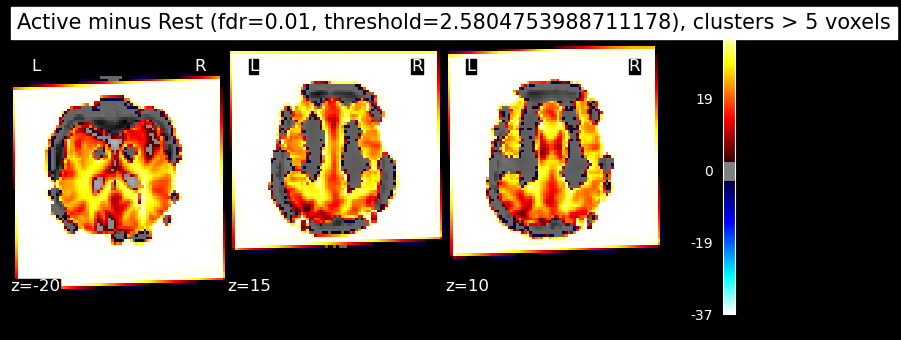

In [89]:
from nilearn.glm import threshold_stats_img

#Link to threshold_stats_img function documentation
#https://nilearn.github.io/dev/modules/generated/nilearn.glm.threshold_stats_img.html

cluster_size = 5 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.01 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-20,15,10], black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()